In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from nPoisson import PoissonSolver

%matplotlib inline
# %matplotlib notebook

from scipy.interpolate import Rbf

In [41]:
def interp_grid(x, y, dx, dy):
    Nx = 30
    Ny = 30
    xx = np.linspace(0, 0.045, Nx)
    yy = np.linspace(0, 0.045, Ny)
    XX, YY = np.array(np.meshgrid(xx, yy))

    XXX = XX.ravel()  # flatten
    YYY = YY.ravel()


    interp_x = Rbf(x, y, dx)
    interp_y = Rbf(x, y, dy)

    vx = interp_x(XXX, YYY)
    vy = interp_y(XXX, YYY)
    
    return XXX, YYY, vx, vy

<IPython.core.display.Javascript object>


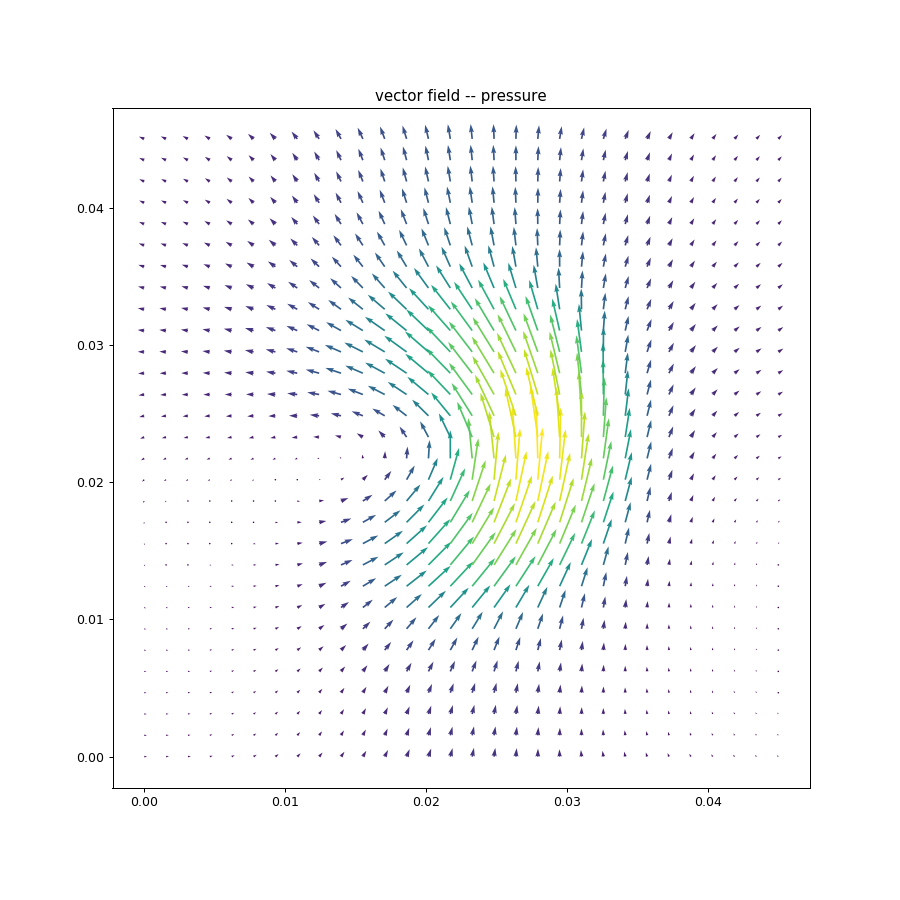

In [52]:
node_origin = pd.read_csv('../FEM_rubber/origin_loc.txt', sep=",", header=None, names=['node_id', 'x', 'y', 'z'])
# print node_origin
node_pressure = pd.read_csv('../FEM_rubber/combined_displacement.txt', sep=" ", 
                            header=None, skipinitialspace=True,
                           names=['magnitude', 'dx', 'dy', 'dz'])
# print node_pressure

# plot nodes and corresponding displacement

x = node_origin['x'].values + 0.0299999993
y = node_origin['y'].values + 0.0350000001
dx = node_pressure['dx'].values
dy = node_pressure['dy'].values

# print x.min(), x.max()
# print y.min(), y.max()

Nx, Ny = 30, 30


XXX, YYY, vx, vy = interp_grid(x, y, dx, dy)

        


vxx = vx.reshape(Nx,Ny)
vyy = vy.reshape(Nx,Ny)    

vfield = np.stack((vxx, vyy), axis=2)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_title('vector field -- pressure')

M = np.hypot(vx,  vy)
Q = ax1.quiver(XXX, YYY, vx,  vy, M,  units='width')



In [30]:
# # read in vector field from file
# df = pd.read_csv('./data/vectors_interp3.csv')

# X = df['x'].values
# Y = df['y'].values
# vx = df['xt'].values
# vy = df['yt'].values



# vxx = vx.reshape(30,30)
# vyy = vy.reshape(30,30)

# vfield = np.stack((vxx, vyy), axis=2)
# print vfield.shape

In [53]:
from pynhhd.nHHD import nHHD

dx = 0.045/29
dy = 0.045/29
grid = (30, 30)

decomposition_obj = nHHD(grid=grid, spacings=(dy, dx))

PoissonSolver: 2 D grid = (30, 30) with spacings (0.0015517241379310344, 0.0015517241379310344)

Initializing Poisson solver, type = F
  - creating distance kernel: (59, 59) 0.0007758621 0.06363961  [[ elapsed time: 0.002 sec. ]]
  - computing the Green's function: (59, 59) -1.1397938 -0.43839532  [[ elapsed time: 0.003 sec. ]]
Poisson solver initialized  [[ elapsed time: 0.007 sec. ]]


In [54]:
import time


start = time.time()

decomposition_obj.decompose(vfield, verbose=1)

print time.time() - start


 ==> nhhd.decompose (30, 30, 2)
div = (30, 30) -0.4394035224439643 0.32960640460776425
curlw = (30, 30) -0.7587442755584195 1.4234858990690333

Solving Poisson Eq.
Poisson solver finished  [[ elapsed time: 0.001 sec. ]]
nD = (30, 30) -3.572115394179238e-05 -2.0756190631672895e-05

Solving Poisson Eq.
Poisson solver finished  [[ elapsed time: 0.001 sec. ]]
nR = (30, 30) -4.6222060018498423e-05 3.4696162556160674e-06
d = (30, 30, 2) -0.0006874329143914308 0.001044031857287285
r = (30, 30, 2) -0.002304647276546318 0.004217275620609359
h = (30, 30, 2) -0.0002980376275994339 0.0006622731435896334
0.00487089157104


In [55]:
d = decomposition_obj.d
h = decomposition_obj.h
r = decomposition_obj.r

-0.011254543733968336 0.9812437127391065


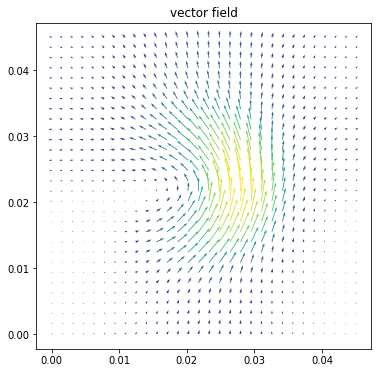

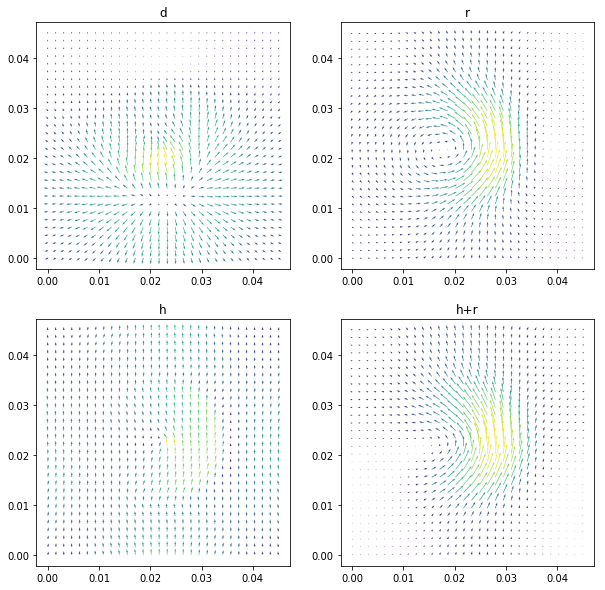

In [58]:
%matplotlib inline

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('vector field')

M = np.hypot(vx,  vy)
Q = ax1.quiver(XXX, YYY, vx,  vy, M,  units='width')
vx_sum = np.sum(vx)
vy_sum = np.sum(vy)

print vx_sum, vy_sum



start = time.time()
fig, ax = plt.subplots(2, 2, subplot_kw=dict(), figsize=(10, 10))
ax[0,0].set_title('d')
M = np.hypot(d[:,:,0],  d[:,:,1])
Q = ax[0,0].quiver(XXX, YYY, d[:,:,0],  d[:,:,1], M,  units='width')


ax[0,1].set_title('r')
M = np.hypot(r[:,:,0],  r[:,:,1])
Q = ax[0,1].quiver(XXX, YYY, r[:,:,0],  r[:,:,1], M,  units='width')


ax[1,0].set_title('h')
M = np.hypot(h[:,:,0],  h[:,:,1])
Q = ax[1,0].quiver(XXX, YYY, h[:,:,0],  h[:,:,1], M,  units='width')


v = d+r+h
# ax[1,1].set_title('d+r+h')
# M = np.hypot(v[:,:,0],  v[:,:,1])
# Q = ax[1,1].quiver(X, Y, v[:,:,0],  v[:,:,1], M,  units='width')


# --------------------------------------------
m = v #- d
ax[1,1].set_title('h+r')
M = np.hypot(m[:,:,0],  m[:,:,1])
Q = ax[1,1].quiver(XXX, YYY, m[:,:,0],  m[:,:,1], M,  units='width')

# print d.shape

# print decomposition_obj.mesh.divcurl(r)

In [35]:
# calculate the totoal amount of individual field and compare with 
# the response of single force excitation.
# print np.hypot(d[:,:, 0], d[:,:,1])

d_mag_sum = np.sum(np.hypot(d[:,:, 0], d[:,:,1]))
print d_mag_sum

node_compress = pd.read_csv('../FEM_rubber/compress_displacement.txt', sep=" ", 
                            header=None, skipinitialspace=True,
                           names=['magnitude', 'dx', 'dy', 'dz'])
# print node_compress
dx_c = node_compress['dx'].values
dy_c = node_compress['dy'].values
_, _, vx_c, vy_c = interp_grid(x, y, dx_c, dy_c)

v_c_sum = np.sum(np.hypot(vx_c, vy_c))
print v_c_sum

0.05684696673133814
0.29061453304514834


In [36]:
D = decomposition_obj.nD
R = decomposition_obj.nRu
print D.shape
rot_ind = np.argmax(R)
print rot_ind
rot_center = (X[rot_ind],Y[rot_ind])
print rot_center

(30, 30)
870


NameError: name 'X' is not defined

In [ ]:
# calculate the directional value
print d.shape
sum_d = np.sum(d.reshape(Nx*Ny, -1), axis=0)
print sum_d
sum_r = np.sum(r.reshape(Nx*Ny, -1), axis=0)
print sum_r

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

# fig = plt.figure(figsize=(8, 8))
# ax = Axes3D(fig)
# ax.scatter3D(X, Y, R)

Nx = 30
Ny = 30

X_ = X.reshape(Nx*Ny)
Y_ = Y.reshape(Nx*Ny)

print X_.shape
rot_max_ind = np.argmax(R)
print rot_max_ind
rot_max_loc = (X_[rot_max_ind], Y_[rot_max_ind])

rot_min_ind = np.argmin(R)
rot_min_loc = (X_[rot_min_ind], Y_[rot_min_ind])

# validate using first derivative
X = X_.reshape(Nx, Ny)
Y = Y_.reshape(Nx, Ny)

i_max = rot_max_ind // Nx
j_max = rot_max_ind % Nx

i_min = rot_min_ind // Nx
j_min = rot_min_ind % Nx

# validate with finite difference symbols
if (R[i_max, j_max] - R[i_max - 1, j_max]) > 0 and (R[i_max + 1, j_max] - R[i_max, j_max]) < 0:
    if (R[i_max, j_max] - R[i_max, j_max - 1]) > 0 and (R[i_max, j_max + 1] - R[i_max, j_max]) < 0:
        # this point is the local minima
        print 'max exist'
        Max = rot_max_loc
    else:

        Max = None
else:
    Max = None
    
print Max